# Predicting the sentiment of tweets related to Apple and Google products

Business problem: classifying the sentiment of tweets to help Apple identify areas where they can improve customer satisfaction.

The structure of this notebook is as follows:

1. Importing relevant packages
2. Exploratory data analysis
3. Data cleaning
4. Feature engineering
5. Data filtering
6. Joining in prompt-engineered data
7. Modeling
8. Results and recommendations

In [214]:
# Data handling and computation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Model selection and validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Pipeline library for efficient workflow
from sklearn.pipeline import Pipeline, make_pipeline

# Metrics libraries for evaluating model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, roc_curve, auc, accuracy_score, confusion_matrix, precision_score, roc_auc_score
from sklearn import metrics

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Ignore warning messages
from warnings import filterwarnings
filterwarnings("ignore")


In [215]:
# Read in data locally
df = pd.read_csv('data/Tweets.csv', encoding='latin1')

# Read in data using google colab/drive
#df = pd.read_csv('/content/drive/MyDrive/Flatiron/project_4/tweets.csv', encoding='latin1')

In [216]:
numerical_features = list(df.select_dtypes("number"))
categorical_features = list(df.select_dtypes("object"))

#print(f'Numerical Columns: \n{numerical_features}\n')
#print(f'Categorical Columns: \n{categorical_features}')

## EDA

In [217]:
df.head();

In [218]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [219]:
df.nunique().sort_values(ascending=True);

In [220]:
df.isna().sum().sort_values(ascending=False);

In [221]:
df.corr();


## Data Cleaning

In [222]:
# Lowercase
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

# Renaming columns to better reflect the data
rename_cols = {
      'tweet_text': 'tweet',
      'emotion_in_tweet_is_directed_at': 'tweet_is_directed_at',
      'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
              }
df = df.rename(columns=rename_cols)


# rename values in the 'emotion' column
rename_values = {
      'no emotion toward brand or product': 'no emotion',
      'positive emotion': 'positive',
      'negative emotion': 'negative',
      "i can't tell": 'unsure'
              }
df['emotion'] = df['emotion'].map(rename_values)


# Dropping (1) single row from df['tweet_text']
df.dropna(subset=['tweet'], inplace=True)


# Filter out 17 tweets that contain both Apple & Google
apple_and_google = ~((df['tweet_is_directed_at'].isna()) &
                   (df['tweet'].str.contains('google')) &
                   (df['tweet'].str.contains('apple')))
df = df[apple_and_google]



## Create assert statements to confirm the code achieved its goals:

assert df.loc[(df['tweet_is_directed_at'].isna()) & (df['tweet'].str.contains('google')) & (df['tweet'].str.contains('apple')), 'tweet'].empty


## Feature Engineering

In [223]:
# Create column of with the character length of the tweet
df['character_count'] = df['tweet'].apply(len)


# Create column of with the word count of the tweet
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))


# Creat column to determine if the tweet was negative toward a brand or not
df['is_tweet_negative'] = df['emotion'].apply(lambda x: 1 if x == 'negative' else 0 if x == 'positive' else 2)

# What company is the tweet about?
renamed_values = {
      'ipad': 1, 'ipad or iphone app': 1,
      'iphone': 1, 'other google product or service': 0,
      'android app': 0, 'android': 0, 'google': 0,
      'other apple product or service': 1, 'apple': 1
                 }
df['is_apple'] = df['tweet_is_directed_at'].map(renamed_values).astype('Int64')


# Creating a feature call 'number_of_mentions' to count @mentions
df['number_of_mentions'] = df['tweet'].str.count('@\w+')


# Create a feature 'hashtags_count' to count hashtags
df['hashtags_count'] = df['tweet'].str.count('#')


# Create feature named 'average_word_length'
df['average_word_length'] = df['tweet'].apply(lambda x: np.mean([len(word) for word in x.split()]))

# Adding column to tell if data was generated by chatgpt data
df['chatgpt_data'] = 0


## Data Filtering

In [224]:
# Assigning unknown tweet to company based on 'apple_words'
apple_words = ['apple', 'iphone','ipod','ipad', 'i-pad', 'app store', 'itunes']
apple_regex = '|'.join(apple_words)  # creates the string 'apple|iphone|ipod|ipad|i-pad'

df.loc[(df['is_apple'].isna()) & df['tweet'].str.contains(apple_regex, case=False), 'is_apple'] = 1


# Assigning unknown tweet to company based on 'google_words'
google_words = ['google', 'android','pixel', 'google play']
google_regex = '|'.join(google_words)  # creates the string 'google|android|pixel|google play'

df.loc[(df['is_apple'].isna()) & df['tweet'].str.contains(google_regex, case=False), 'is_apple'] = 0


# Dropping tweets that have no mention of either Apple or Google
df.dropna(subset=['is_apple'], inplace=True)


# Drop the column 'tweet_is_directed_at' due to many missing values
#df = df.drop(columns=['tweet_is_directed_at'])

## Import and Join Negative Tweet Data (via ChatGPT prompt engineering)

In [225]:
# Read in data locally
neg_tweets = pd.read_csv('data/chatgpt_tweet_data.csv')

# Read in data using google colab/drive
#neg_tweets = pd.read_csv('/content/drive/MyDrive/Flatiron/project_4/chatgpt_tweet_data.csv')

# Lowercase
neg_tweets = neg_tweets.applymap(lambda s:s.lower() if type(s) == str else s)

# Adding column to tell if data was generated by chatgpt data
neg_tweets['chatgpt_data'] = 1

In [226]:
# Create a dictionary of emojis
emojis= {
'😒' : '[grumpy]',
'😡' : '[angry]',
'🤬' : '[cursing]',
'😞' : '[disappointed]',
'😤' : '[frustrated]',
'😭' : '[crying]',
'🤦‍♂️' : '[facepalmboy]',
'😑' : '[displeased]',
'😢' : '[tearful]',
'😱' : '[spooked]',
'😂' : '[laughing]',
'😄' : '[smiling]',
'😝' : '[silly]',
'🙄' : '[eyeroll]',
'😏' : '[smirking]',
'🤔' : '[confused]',
'🗳️' : '[voting]',
'📈' : '[stockup]',
'📉' : '[stockdown]',
'😩' : '[distressed]',
'😠' : '[mad]',
'😓' : '[unhappy]',
'🤣' : '[laughter]',
'😕' : '[uhoh]',
'🙅‍♂️' : '[crossarmsblue]',
'🤳' : '[arm]',
'🙅‍♀️' : '[crossarmspurple]',
'🔋' : '[battery]',
'😆' : '[bigsmile]',
'🤦‍♀️' : '[facepalmgirl]',
'📱' : '[phone]',
'😫' : '[distressed]',
'😅' : '[lmao]',
'🤨' : '[raisedeyebrow]',
'😔' : '[sad]',
'😖' : '[yikes]'
}

# Create a function to convert emojis to text
def emoji_fixer(x):
    for k in emojis.keys():
        x=x.replace(k, emojis[k])
    return x

# Apply the function to tweets column
neg_tweets['tweet']=neg_tweets['tweet'].apply(emoji_fixer)

In [227]:
#Join Dataframes
df = pd.concat([df, neg_tweets], ignore_index=True)

In [228]:
df['is_tweet_negative'].value_counts();

## Modeling

In [229]:
# You might need to download these if you haven't already
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Function to preprocess tweets
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s@#]', ' ', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    tweet = re.sub(r'^b\s+', '', tweet)
    tweet = tweet.split()
    tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in stop_words]
    tweet = ' '.join(tweet)
    return tweet


# Apply preprocessing function to tweets
df['processed_tweet'] = df['tweet'].apply(preprocess)


# Feature extraction with TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_tweet']).toarray()
y = df['is_tweet_negative']


# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Print the original class distribution
print('Original class distribution: \n', y_train.value_counts())


# Train the model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original class distribution: 
 2    3867
0    2379
1    2330
Name: is_tweet_negative, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.44      0.51       588
           1       0.94      0.81      0.87       590
           2       0.66      0.82      0.73       966

    accuracy                           0.72      2144
   macro avg       0.73      0.69      0.70      2144
weighted avg       0.72      0.72      0.71      2144

Accuracy: 0.715018656716418


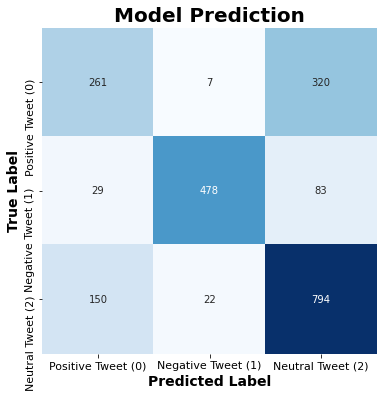

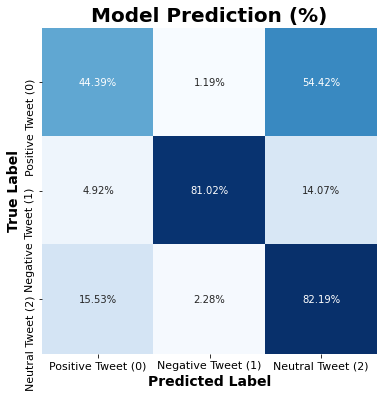

              precision    recall  f1-score   support

           0       0.59      0.44      0.51       588
           1       0.94      0.81      0.87       590
           2       0.66      0.82      0.73       966

    accuracy                           0.72      2144
   macro avg       0.73      0.69      0.70      2144
weighted avg       0.72      0.72      0.71      2144

Accuracy: 0.715018656716418


In [230]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    if normalize:
        cm_df = cm_df.div(cm_df.sum(axis=1), axis=0)

    fig, ax = plt.subplots(figsize=(6, 6))

    sns.heatmap(cm_df, annot=True, fmt=".2%" if normalize else "d", cmap='Blues', ax=ax, cbar=False)

    ax.set_title('Model Prediction' + (' (%)' if normalize else ''), fontsize=20, weight='bold')
    ax.set_xlabel('Predicted Label', fontsize=14, weight='bold')
    ax.set_ylabel('True Label', fontsize=14, weight='bold')

    # Define the labels
    labels = ['Positive Tweet (0)', 'Negative Tweet (1)', 'Neutral Tweet (2)']

    # Set the tick labels with increased size
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_yticklabels(labels, fontsize=11)

    plt.show()

# Set classes
classes = [0, 1, 2]

# Plot the non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes)

# Plot the normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Test Precision (micro): 0.715018656716418
Train Precision (micro): 0.7859141791044776
Test Precision (macro): 0.733102528750302
Train Precision (macro): 0.8061353828443433
Test Precision (weighted): 0.7209959442158139
Train Precision (weighted): 0.7922524126312606


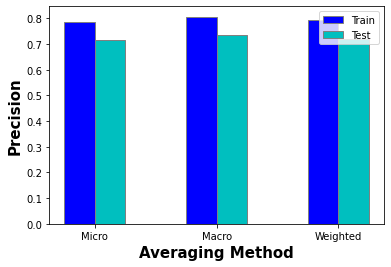

In [231]:
# Train the model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# Calculate precision
precision_test_micro = precision_score(y_test, y_pred_test, average='micro')
precision_train_micro = precision_score(y_train, y_pred_train, average='micro')

precision_test_macro = precision_score(y_test, y_pred_test, average='macro')
precision_train_macro = precision_score(y_train, y_pred_train, average='macro')

precision_test_weighted = precision_score(y_test, y_pred_test, average='weighted')
precision_train_weighted = precision_score(y_train, y_pred_train, average='weighted')

# Print precision
print("Test Precision (micro):", precision_test_micro)
print("Train Precision (micro):", precision_train_micro)
print("Test Precision (macro):", precision_test_macro)
print("Train Precision (macro):", precision_train_macro)
print("Test Precision (weighted):", precision_test_weighted)
print("Train Precision (weighted):", precision_train_weighted)

# Plot precision
bar_width = 0.25
r1 = np.arange(3)
r2 = [x + bar_width for x in r1]

plt.bar(r1, [precision_train_micro, precision_train_macro, precision_train_weighted], color='b', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, [precision_test_micro, precision_test_macro, precision_test_weighted], color='c', width=bar_width, edgecolor='grey', label='Test')

# Adding xticks
plt.xlabel('Averaging Method', fontweight='bold', fontsize=15)
plt.ylabel('Precision', fontweight='bold', fontsize=15)
plt.xticks([r + bar_width/2 for r in range(3)], ['Micro', 'Macro', 'Weighted'])
plt.legend()

plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


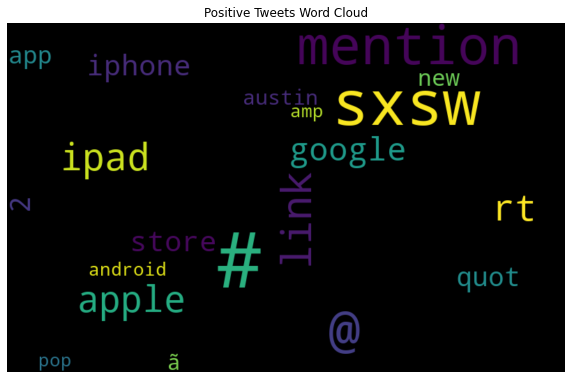

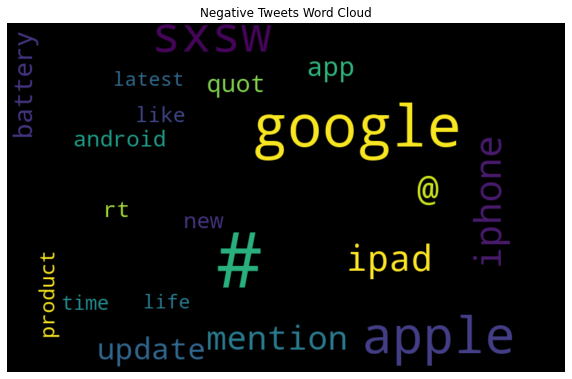

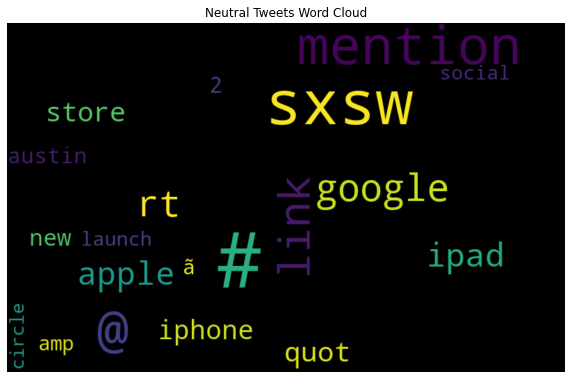

In [232]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Separate tweets by class
positive_tweets = df[df['is_tweet_negative'] == 0]['processed_tweet']
negative_tweets = df[df['is_tweet_negative'] == 1]['processed_tweet']
neutral_tweets = df[df['is_tweet_negative'] == 2]['processed_tweet']

# Join the different processed titles together.
positive_words = ' '.join(positive_tweets)
negative_words = ' '.join(negative_tweets)
neutral_words = ' '.join(neutral_tweets)

# Tokenize the words and count the frequency
positive_word_freq = Counter(word_tokenize(positive_words))
negative_word_freq = Counter(word_tokenize(negative_words))
neutral_word_freq = Counter(word_tokenize(neutral_words))

# Select top 20 most frequent words for each class
positive_most_common = dict(positive_word_freq.most_common(20))
negative_most_common = dict(negative_word_freq.most_common(20))
neutral_most_common = dict(neutral_word_freq.most_common(20))

# Create word clouds
wordcloud_positive = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(positive_most_common)
wordcloud_negative = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(negative_most_common)
wordcloud_neutral = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(neutral_most_common)

# Plot word clouds
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Tweets Word Cloud')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis('off')
plt.title('Negative Tweets Word Cloud')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis('off')
plt.title('Neutral Tweets Word Cloud')
plt.show()


## Model 2

In [233]:
df.head();

In [234]:
# Function to fit model and print classification report.
def model_tester(model, X_train=X_train, y_train=y_train):
    model.fit(X_train, y_train)
    print(classification_report(y_test, model.predict(X_test)))


In [235]:
# Function to perform grid search and print classification report for best parameters. Also prints RMSE and ROC-AUC score.
def model_best_param_tester(model, params, X_train=X_train, y_train=y_train):
    gridsearch=GridSearchCV(model, param_grid=params)
    gridsearch.fit(X_train, y_train)
    y_preds=gridsearch.predict(X_test)
    rmse=round(np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error')).mean(),3)
    lb = LabelBinarizer()
    y_preds_binarized=lb.fit_transform(y_preds).flatten()
    y_test_binarized=lb.transform(y_test).flatten()
    roc_auc=round(roc_auc_score(y_test_binarized, y_preds_binarized), 3)
    
    print(f'The best model parameters are {gridsearch.best_params_}')
    print(f'Root Mean Squared Error for model is {rmse}')
    print(f'ROC-AUC score for model is {roc_auc}')

    return model_tester(gridsearch.best_estimator_)

In [236]:
# Initializing the models we will test out.
logreg=LogisticRegression()
bayes=MultinomialNB()
dtc=DecisionTreeClassifier()
rfc=RandomForestClassifier()
xg=xgb.XGBClassifier()

In [237]:
# Other models which were tested

#model_best_param_tester(logreg, {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear', 'newton-cg']})
#model_best_param_tester(bayes, {'fit_prior': [True, False], 'alpha': [0.001, 0.01, 0.1, 1]})
#model_best_param_tester(dtc, {'max_depth': [1,2,3,4,5], 'max_features': [1,2,3,4]})
#model_best_param_tester(rfc, {'n_estimators': [100, 150], 'max_features': [1,'sqrt', 'log2'], 'criterion': ['gini', 'entropy']})

In [238]:
model_best_param_tester(xg, {'booster': ['gbtree', 'gblinear' 'dart']})


The best model parameters are {'booster': 'gbtree'}
Root Mean Squared Error for model is 0.953
ROC-AUC score for model is 0.785
              precision    recall  f1-score   support

           0       0.59      0.39      0.47       588
           1       0.95      0.81      0.88       590
           2       0.65      0.85      0.74       966

    accuracy                           0.71      2144
   macro avg       0.73      0.68      0.70      2144
weighted avg       0.72      0.71      0.70      2144



In [239]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer=CountVectorizer()
apple_vectorized=count_vectorizer.fit_transform(df.loc[(df['is_tweet_negative']==1) & (df['is_apple']==1)]['processed_tweet'])

apple_data=pd.DataFrame(data=apple_vectorized.toarray(), columns=count_vectorizer.get_feature_names())
#Please note depending on your version of python you may need to run apple_data=pd.DataFrame(data=apple_vectorized.toarray(), columns=count_vectorizer.get_feature_names_out())

text=''
for a in apple_data.sum().sort_values(ascending=False)[:20].index:
    text=text+a+' '
text
WordCloud().generate(text)

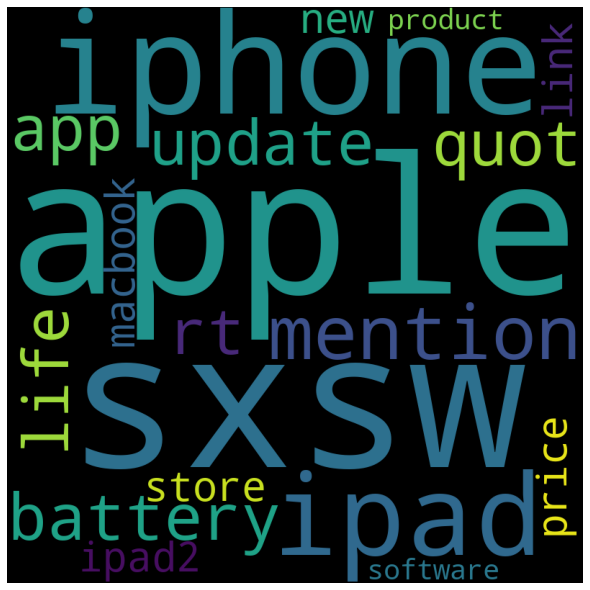

In [240]:

# Your existing code
count_vectorizer = CountVectorizer()
apple_vectorized = count_vectorizer.fit_transform(df.loc[(df['is_tweet_negative'] == 1) & (df['is_apple'] == 1)]['processed_tweet'])

apple_data = pd.DataFrame(data = apple_vectorized.toarray(), columns = count_vectorizer.get_feature_names())
#Please note depending on your version of python you may need to instead run apple_data = pd.DataFrame(data = apple_vectorized.toarray(), columns = count_vectorizer.get_feature_names_out())

text = ''
for a in apple_data.sum().sort_values(ascending = False)[:20].index:
    text = text + a + ' '

# Generate WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = None,
                min_font_size = 10).generate(text)

# Plot WordCloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


## Results and Recommendations

The Gradient Boosting Classifier with default parameters has the best performance of all the models examined.

From looking at the wordcloud, we can see battery, life, update, and price are some of the common topics that appear in negative tweets. Therefore we recommend to Apple to focus on improving these areas in order to reduce negative sentiment. 